In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm,t,uniform,f
from sklearn.linear_model import LinearRegression
import termcolor
from numba.experimental import jitclass

def rprint(string):
    print(termcolor.colored(string, color='green'))

In [2]:

class LassoRegression:
    def __init__(self, alpha=1.0, learning_rate=0.005, max_iter=100000, tol=1e-4):
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.coef_ = None
    
    def _soft_threshold(self, x, threshold):
        return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

    
    def fit(self, X, omg,_=np.array([1.,1.])):
        # Добавляем столбец единиц для intercept
        minprice = np.inf
        svalka = [_]
        best = None
        
        for _ in range(self.max_iter):
            if len(svalka)==_:
                break
            for i in range(2):
                tmpcoef = svalka[_]
                tmpcoef[i]-=self.learning_rate
                y_pred = tmpcoef@X.T
                price = (y_pred - omg).T @ (y_pred - omg) +sum(abs(k) for k in tmpcoef)*self.alpha
                if price < minprice:
                    minprice = price
                    svalka.append(np.array(tmpcoef))
                    best = tmpcoef
                    continue
                tmpcoef[i]+=2*self.learning_rate
                y_pred = tmpcoef@X.T
                price =(y_pred - omg).T @ (y_pred - omg) +sum(abs(k) for k in tmpcoef)*self.alpha
                if price < minprice:
                    minprice = price
                    svalka.append(np.array(tmpcoef))
                    best = tmpcoef
        self.coef_ = best
    
    def predict(self, X):
        return X@self.coef_


class RidgeRegression:
    def __init__(self, alpha=1.0, learning_rate=0.001, max_iter=100000, tol=1e-4):
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.coef_ = None
    
    def _soft_threshold(self, x, threshold):
        return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)
    

    def fit(self, X, omg, _=np.array([1.,1.])):
        # Добавляем столбец единиц для intercept
        minprice = np.inf
        svalka = [_]
        best = None
        
        for _ in range(self.max_iter):
            if len(svalka)==_:
                break
            for i in range(2):
                tmpcoef = svalka[_]
                tmpcoef[i]-=self.learning_rate
                y_pred = X@tmpcoef
                price = (y_pred - omg).T @ (y_pred - omg) +sum(k**2 for k in tmpcoef)*self.alpha
                if price < minprice:
                    minprice = price
                    svalka.append(np.array(tmpcoef))
                    best = tmpcoef
                    continue
                tmpcoef[i]+=2*self.learning_rate
                y_pred = X@tmpcoef
                price =(y_pred - omg).T @ (y_pred - omg) +sum(k**2 for k in tmpcoef)*self.alpha
                if price < minprice:
                    minprice = price
                    svalka.append(np.array(tmpcoef))
                    best = tmpcoef
        self.coef_ = best
    
    def predict(self, X):
        return X@self.coef_

X = np.array([[1,0,1],[0,1,5],[1,1,2]])

model_rid = LassoRegression(alpha=0)
model_rid.fit(X[:,:2], X[:,2])
model_rid.coef_, model_rid.predict(X[0,:2])

(array([-0.325,  3.655]), np.float64(-0.3250000000000011))

In [3]:
X = np.array([[1,0,1],[0,1,5],[1,1,2]])
omg=np.array([1,5,2])

In [4]:
model_lin = LinearRegression(fit_intercept=False)
model_lin.fit(X[:,:2], X[:,2])

LinearRegression(fit_intercept=False)

In [5]:
model_lin.coef_

array([-0.33333333,  3.66666667])

In [6]:
def CUSS(model, X, omg):
    res=(omg-model.predict(X))@(omg-model.predict(X))
    return res

In [7]:
las=[]
rid=[]
alfs=[]
omgs=np.array([[5.,2.],[1,2],[1,5]])

N=1000
m = 100.
_=np.array([1.,1.])
for i in range(0,N):
    alf = i/m
    tmp=0.
    for j in range(3):
        model_las = LassoRegression(alpha=alf)
        X_=np.delete(X,j,0)
        model_las.fit(X_[:,:2], omgs[j], _)
        _=model_las.coef_
        tmp+=CUSS(model_las,X[:,:2], omg)
    las.append(tmp)
    _=model_las.coef_
    alfs.append(alf)
model_las.predict(X[:2].T)


array([4.29657178e-12, 5.00000002e-03, 2.50000001e-02])

In [8]:
minid=0
mincuss=10000000000000000
for i in range(len(las)):
    if(las[i]<mincuss):
        minid=i
        mincuss=las[i]
    

lasso:
	alf=1.45
	CUSS=36.33834999994359


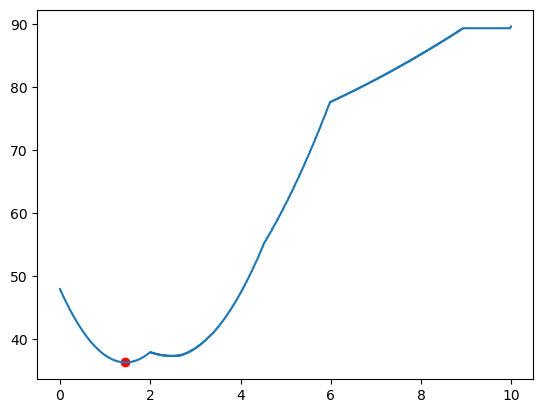

In [9]:
plt.plot([i/m for i in range(0,N)], las)
plt.scatter(minid/m,mincuss,color="red")
rprint(f"lasso:\n\talf={minid/m}\n\tCUSS={mincuss}")
#plt.xlim(-10,10)

In [10]:
rid=[]
alfs=[]
N=200
m = 100.
_=np.array([1.,1.])
omgs=np.array([[5.,2.],[1,2],[1,5]])
for i in range(0,N):
    alf = i/m
    tmp=0.
    for j in range(3):
        model_rid = RidgeRegression(alpha=alf)
        X_=np.delete(X,j,0)
        model_rid.fit(X_[:,:2], omgs[j], _)
        _=model_rid.coef_
        tmp+=CUSS(model_rid,X[:,:2], omg)
    rid.append(tmp)
    alfs.append(alf)
model_rid.predict(X[:2].T)

array([0.334, 1.672, 8.694])

In [11]:
minid=0
mincuss=10000000000000000
for i in range(len(rid)):
    if(rid[i]<mincuss):
        minid=i
        mincuss=rid[i]


ridge:
	alf=0.46
	CUSS=32.01047600001589


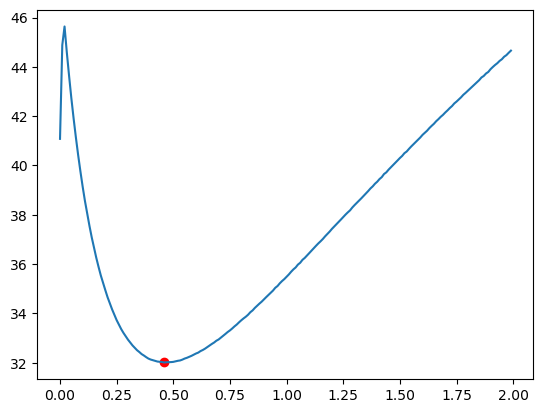

In [12]:
plt.plot([i/m for i in range(0,N)], rid)
plt.scatter(minid/m,mincuss,color="red")
rprint(f"ridge:\n\talf={minid/m}\n\tCUSS={mincuss}")
